## PySpark Analysis of Flying Etiquette Survey Data

[Dataset:](flying.csv) containing passengers' survey responses on airplane etiquette.

Submited by: **[Biplov Gautam](https://github.com/biplovgautam)**

Submitted to: **Mr. Siddhartha Neupane**


### Imports and Spark Session builder


In [27]:
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
from pyspark.sql import SparkSession
from pyspark.sql.functions import col, when, trim, count, desc, round

#Initialize Spark Session
spark = SparkSession.builder.appName("Flying Etiquette Analysis").getOrCreate()


## Part a) Frequency of Air Travel
#### Write PySpark code to:

-  Load the "flying.csv" dataset using PySpark

- Construct a horizontal bar chart of the frequency variable (answers to "How often do you travel by plane?")

- Include a suitable title and proper axis labels

- Display the counts in descending order


### Requirements:

- Include your PySpark code

- Include the resulting bar chart

- Briefly describe the distribution of travel frequency among respondents

## Solution

+--------------------+-----+
|           frequency|count|
+--------------------+-----+
| Once a year or less|  611|
|Once a month or less|  198|
|               Never|  164|
|A few times per m...|   29|
|           Every day|    3|
|A few times per week|    2|
+--------------------+-----+



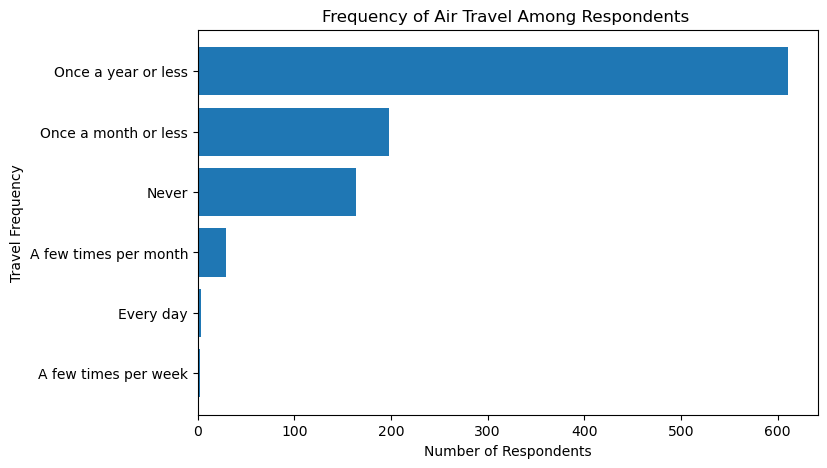

In [28]:
# Load the dataset 
# inferSchema=True helps Spark guess the data types, and header=True uses the first row as column names.
df = spark.read.csv("flying.csv", header=True, inferSchema=True)

# 3. Quick check of the data structure
# df.printSchema() uncomment this if you wanna print schema
# df.show(5)

# basic cleaning
# Replace "NA" with null in all columns
for c in df.columns:
    df = df.withColumn(c,when(trim(col(c)) == "NA", None).otherwise(trim(col(c))))


# Step 1: Filter valid rows
freq_df = df.filter(col("frequency").isNotNull())

# Step 2: Count & sort
freq_counts = (
    freq_df
    .groupBy("frequency")
    .agg(count("*").alias("count"))
    .orderBy(desc("count"))
)
freq_counts.show()

# Step 3: Convert to Pandas (for plotting)
freq_pd = freq_counts.toPandas()

# Step 4: Horizontal Bar Chart
plt.figure(figsize=(8, 5))
plt.barh(freq_pd["frequency"], freq_pd["count"])
plt.xlabel("Number of Respondents")
plt.ylabel("Travel Frequency")
plt.title("Frequency of Air Travel Among Respondents ")
plt.gca().invert_yaxis()
plt.show()


### Distribution Description: (Part a)
- Most respondents travel once a year or less

- Very few respondents travel frequently (monthly or daily)

- This indicates the dataset is dominated by occasional flyers, not frequent travelers
---

## Part b) Children and Attitudes Toward Babies on Planes

#### Consider the variables:

- children_under_18 (answers to "Do you have any children under 18?")
- baby (answers to "In general, is it rude to bring a baby on a plane?")

### Write PySpark code to:

- Remove any rows where either of these two variables is null
- Construct an appropriate graphical plot showing the relationship between the two variables (e.g., grouped bar chart, stacked bar chart, or cross-tabulation visualization)
- Include your PySpark code, graphical plot, and a written conclusion

### Questions to address in your conclusion:

- What is the relationship between having children under 18 and attitudes toward babies on planes?
- Do parents and non-parents have significantly different views?
- What patterns or trends do you observe?

## Solution

+-----------------+--------+-----+
|children_under_18|    baby|count|
+-----------------+--------+-----+
|            FALSE|    Very|   67|
|             TRUE|      No|  157|
|            FALSE|      No|  428|
|            FALSE|Somewhat|  157|
|             TRUE|Somewhat|   23|
|             TRUE|    Very|    7|
+-----------------+--------+-----+

+-----------------+---+--------+----+
|children_under_18| No|Somewhat|Very|
+-----------------+---+--------+----+
|            FALSE|428|     157|  67|
|             TRUE|157|      23|   7|
+-----------------+---+--------+----+



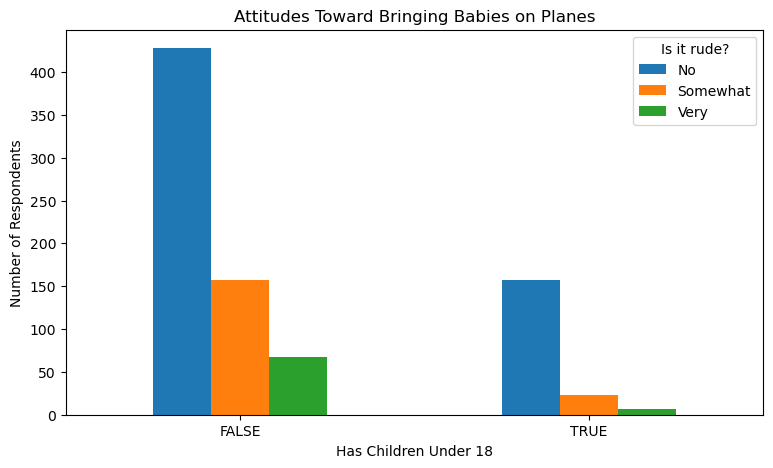

In [29]:
# Step 1: Clean & Filter
children_baby_df = df.filter(
    col("children_under_18").isNotNull() &
    col("baby").isNotNull()
)

# step 2: cross tabulation
children_baby_ct = (
    children_baby_df
    .groupBy("children_under_18", "baby")
    .agg(count("*").alias("count"))
)
children_baby_ct.show()

# Step 3: Pivot for Visualization
pivot_cb = (
    children_baby_ct
    .groupBy("children_under_18")
    .pivot("baby")
    .sum("count")
    .fillna(0)
)
pivot_cb.show()

# Step 4: Plot (Grouped Bar Chart)
cb_pd = pivot_cb.toPandas().set_index("children_under_18")

cb_pd.plot(
    kind="bar",
    figsize=(9, 5)
)

plt.xlabel("Has Children Under 18")
plt.ylabel("Number of Respondents")
plt.title("Attitudes Toward Bringing Babies on Planes")
plt.legend(title="Is it rude?")
plt.xticks(rotation=0)
plt.show()


### Conclusion (Part b)
#### Relationship Observed:

- Parents (TRUE) are more likely to say bringing a baby is not rude
- Non-parents (FALSE) show a higher tendency to label it somewhat or very rude

#### Interpretation:

- Personal experience strongly affects perception
- Parents appear more empathetic to traveling with infants
- Clear attitudinal difference exists between parents and non-parents

## Part c) Age Groups and Reclining Seats Behavior
### Consider the variables:

- age (respondent's age group)
- recline (answers to "Is it rude to recline your seat on a plane?")

### Write PySpark code to:

- Filter out any rows with null values in either variable
- Create a contingency table showing the relationship between age groups and opinions on reclining seats
- Calculate the percentage of respondents in each age group who think it is rude to recline
- Create a grouped or faceted bar chart displaying these percentages by age group
- Interpret your findings: Which age groups are most likely to consider seat reclining rude? Is there a clear trend?

**Include in your answer:** PySpark code, contingency table, percentage calculations, visualization, and interpretation.

+-----+------------+-----+
|  age|recline_rude|count|
+-----+------------+-----+
|18-29|          No|   78|
|18-29|        Very|   20|
|30-44|        Very|   15|
| > 60|          No|  133|
|45-60|          No|  140|
| > 60|    Somewhat|   61|
|45-60|    Somewhat|   80|
|30-44|          No|  143|
|30-44|    Somewhat|   64|
|18-29|    Somewhat|   74|
| > 60|        Very|   21|
|45-60|        Very|   14|
+-----+------------+-----+

+-----+------------+
|  age|percent_rude|
+-----+------------+
|45-60|       40.17|
|30-44|       35.59|
|18-29|       54.65|
| > 60|       38.14|
+-----+------------+



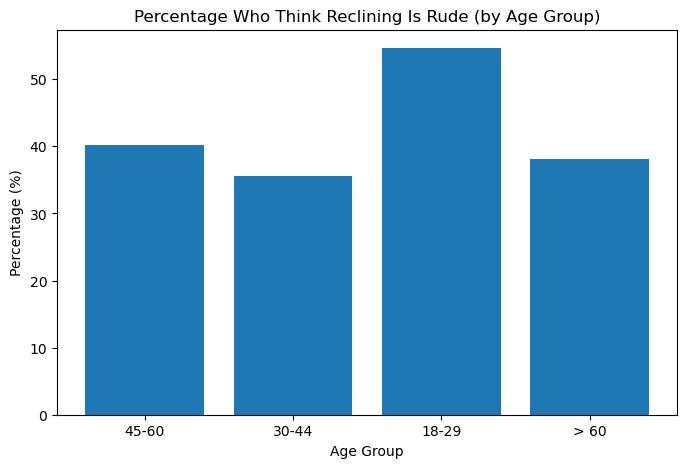

In [30]:


# Step 1: Filter valid data
age_recline_df = df.filter(
    col("age").isNotNull() &
    col("recline_rude").isNotNull()
)

# Step 2: Contingency Table
age_recline_ct = (
    age_recline_df
    .groupBy("age", "recline_rude")
    .agg(count("*").alias("count"))
)

age_recline_ct.show()

# Step 3: Percentage Calculation (Very / Somewhat rude)

# Total respondents per age group
total_by_age = (
    age_recline_df
    .groupBy("age")
    .count()
    .withColumnRenamed("count", "total_count")
)

# Respondents who think reclining is rude
rude_only = (
    age_recline_df
    .filter(col("recline_rude").isin("Very", "Somewhat"))
    .groupBy("age")
    .count()
    .withColumnRenamed("count", "rude_count")
)

# Calculate percentage
percentage_df = (
    rude_only
    .join(total_by_age, on="age")
    .withColumn(
        "percent_rude",
        round((col("rude_count") / col("total_count")) * 100, 2)
    )
    .select("age", "percent_rude")
)

percentage_df.show()

# Step 4: Visualization
perc_pd = percentage_df.toPandas()

plt.figure(figsize=(8, 5))
plt.bar(perc_pd["age"], perc_pd["percent_rude"])
plt.xlabel("Age Group")
plt.ylabel("Percentage (%)")
plt.title("Percentage Who Think Reclining Is Rude (by Age Group)")
plt.show()


### Interpretation (Part c)
- Younger respondents (18–29) are more sensitive to reclining behavior

- Older age groups are generally more tolerant

- Trend suggests etiquette expectations decline with age

---

## Part d) Alcohol Consumption and General Rudeness Perceptions
### Consider the variables:

- alcohol (answers to "Do you drink alcohol while flying?")
- rude (overall perception - answers to "How often do you observe rude behavior on planes?")
### Write PySpark code to:

- Remove rows with null values in either variable
- Calculate summary statistics (count, proportions) for each combination of alcohol consumption and perceived rudeness
- Create an appropriate visualization (e.g., mosaic plot equivalent or heat map) showing the relationship
- Write a brief analysis: Does alcohol consumption appear to be related to how often passengers observe rude behavior? Is there a pattern?

**Include in your answer:** PySpark code, summary statistics, visualization, and interpretation.

In [ ]:
# the columns are missing so couldntr perform in it


## General Requirements for All Parts:
- Use PySpark DataFrames (not RDDs) for all data manipulation

- Use appropriate PySpark methods for filtering, grouping, and aggregation

- Use Python libraries (Matplotlib, Seaborn, or Plotly) for visualizations

- Include comments in your code explaining each step

- Ensure all visualizations have clear titles, axis labels, and legends where appropriate

- Write clear, concise interpretations of your findings

- For each analysis, state any assumptions you're making about the data